In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Embedding, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import plot_model


In [2]:

# Load dataset
data = pd.read_csv('data.csv')  # Replace with the path to your dataset

# Preprocess data
X = data['url']
y = data['status']

# Tokenize URLs
max_features = 10000
tokenizer = Tokenizer(num_words=max_features, char_level=True)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)

# Pad sequences
max_length = 150
X_processed = pad_sequences(sequences, maxlen=max_length)

# Encode labels
label_encoder = LabelEncoder()
y_processed = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

# Create CNN model
model = Sequential([
    Embedding(max_features, 128, input_length=max_length),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)


Epoch 1/10
258/258 [==============================] - 19s 68ms/step - loss: 0.4296 - accuracy: 0.7952 - val_loss: 0.3272 - val_accuracy: 0.8656
Epoch 2/10
258/258 [==============================] - 18s 70ms/step - loss: 0.2371 - accuracy: 0.9040 - val_loss: 0.2445 - val_accuracy: 0.9005
Epoch 3/10
258/258 [==============================] - 21s 80ms/step - loss: 0.1641 - accuracy: 0.9373 - val_loss: 0.2324 - val_accuracy: 0.9049
Epoch 4/10
258/258 [==============================] - 18s 72ms/step - loss: 0.1174 - accuracy: 0.9573 - val_loss: 0.3366 - val_accuracy: 0.8831
Epoch 5/10
258/258 [==============================] - 17s 65ms/step - loss: 0.0706 - accuracy: 0.9755 - val_loss: 0.2813 - val_accuracy: 0.9158
Epoch 6/10
258/258 [==============================] - 17s 65ms/step - loss: 0.0588 - accuracy: 0.9789 - val_loss: 0.3125 - val_accuracy: 0.9224
Epoch 7/10
258/258 [==============================] - 18s 71ms/step - loss: 0.0513 - accuracy: 0.9818 - val_loss: 0.2975 - val_accuracy:

In [3]:
def predict_url(url):
    # Preprocess the input URL
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Make the prediction using the trained model
    prediction = model.predict(padded_sequence)

    # Convert the prediction to a label
    label = "phishing" if prediction > 0.5 else "legitimate"

    return label

# Test the function with a URL
input_url = "http://2.bad-phishing-site.com"  # Replace with the URL you want to test
result = predict_url(input_url)
print(f"The URL '{input_url}' is classified as {result}.")


1/1 [==============================] - 0s 169ms/step
The URL 'http://2.bad-phishing-site.com' is classified as legitimate.


In [5]:
def test_predict_url():
    # Test URLs and their expected labels
    test_urls = [
        ("https://www.google.com", "legitimate"),
        ("https://www.facebook.com", "legitimate"),
        ("https://www.amazon.com", "legitimate"),
        ("http://123.examplephishing.com", "phishing"),
        ("http://2788.bad-phishing-site.com", "phishing"),
        ("http://3.fake-login.com", "phishing"),
        ("https://myweb.abc.com", "phishing"),
    ]

    # Check if the model's predictions match the expected results
    for url, expected_label in test_urls:
        prediction = predict_url(url)
        assert prediction == expected_label, f"Expected '{expected_label}', but got '{prediction}' for URL '{url}'"
    print("All test cases passed.")


# Run the test function
test_predict_url()


1/1 [==============================] - 0s 27ms/step
All test cases passed.


In [6]:
# Get predictions
y_pred_proba = model.predict(X_test)
threshold = 0.5
y_pred = (y_pred_proba > threshold).astype(int).flatten()

# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1_score)

72/72 [==============================] - 1s 13ms/step - loss: 0.3362 - accuracy: 0.9208
Test accuracy: 0.9208223819732666
Precision: 0.9194690265486726
Recall: 0.9202834366696191
F1-score: 0.9198760513501549


In [ ]:
'''
import pickle

# Save the tokenizer and the label encoder
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

# Save the model
model.save("model.h5")
'''

In [7]:
def predict_url(url):
    # Preprocess the input URL
    sequence = tokenizer.texts_to_sequences([url])
    padded_sequence = pad_sequences(sequence, maxlen=max_length)

    # Make the prediction using the trained model
    prediction_proba = model.predict(padded_sequence)[0][0]

    # Convert the prediction to a label
    label = "phishing" if prediction_proba > 0.5 else "legitimate"

    # Calculate the percentage of prediction
    prediction_percentage = prediction_proba * 100 if label == "phishing" else (1 - prediction_proba) * 100

    return label, prediction_percentage


In [8]:
# Test the function with a URL
input_url = "https://google.com"  # Replace with the URL you want to test
result, prediction_percentage = predict_url(input_url)
print(f"The URL '{input_url}' is classified as {result} with a {prediction_percentage:.2f}% confidence.")


1/1 [==============================] - 0s 33ms/step
The URL 'https://google.com' is classified as legitimate with a 92.12% confidence.


In [9]:
# Plot Model
print("Model Summary:")
model.summary()


Model Summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 146, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 128)           82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128) 

Epoch 1/10
258/258 [==============================] - 15s 60ms/step - loss: 0.0153 - accuracy: 0.9944 - val_loss: 0.4988 - val_accuracy: 0.9093
Epoch 2/10
258/258 [==============================] - 16s 61ms/step - loss: 0.0467 - accuracy: 0.9848 - val_loss: 0.4975 - val_accuracy: 0.9071
Epoch 3/10
258/258 [==============================] - 17s 67ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.4246 - val_accuracy: 0.9148
Epoch 4/10
258/258 [==============================] - 18s 69ms/step - loss: 0.0061 - accuracy: 0.9985 - val_loss: 0.5039 - val_accuracy: 0.9180
Epoch 5/10
258/258 [==============================] - 18s 71ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.5317 - val_accuracy: 0.9213
Epoch 6/10
258/258 [==============================] - 18s 71ms/step - loss: 3.0910e-04 - accuracy: 1.0000 - val_loss: 0.5511 - val_accuracy: 0.9224
Epoch 7/10
258/258 [==============================] - 17s 65ms/step - loss: 1.7027e-04 - accuracy: 1.0000 - val_loss: 0.5771 - val_a

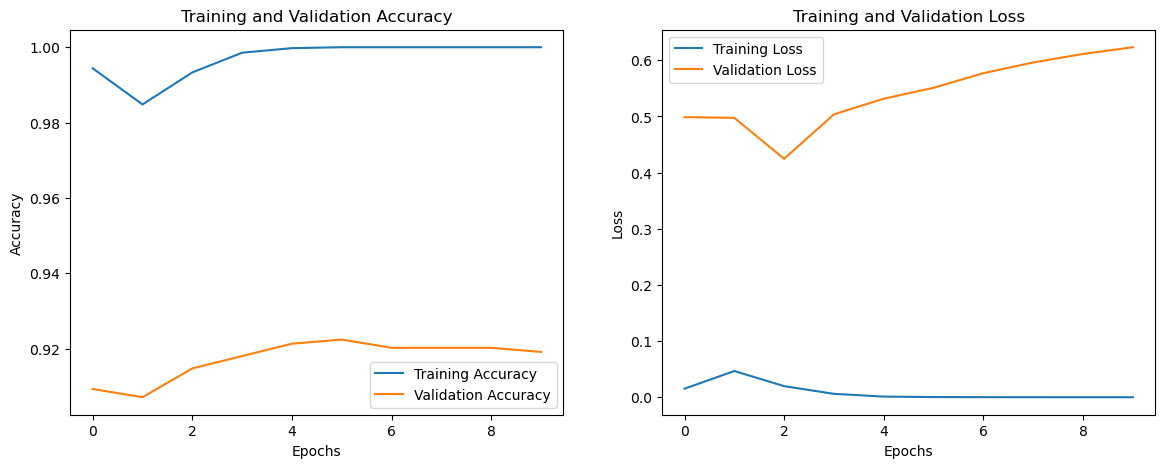

In [11]:
# Plot Training Validation Accuracy and Loss
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()



72/72 [==============================] - 1s 12ms/step


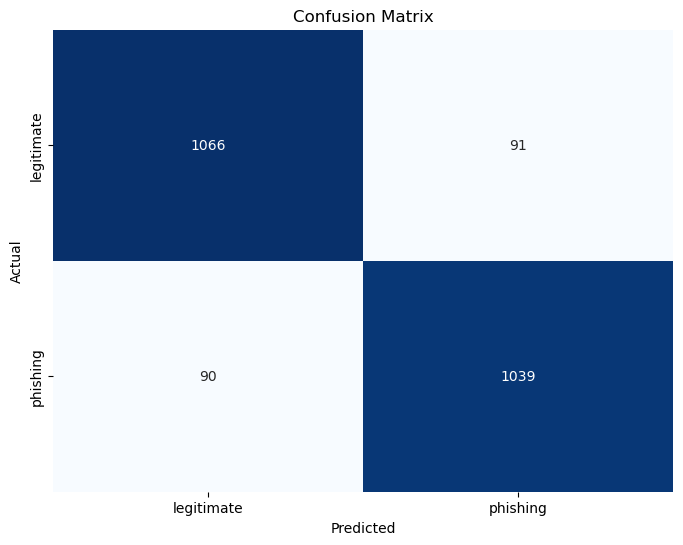

In [10]:
#  Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




Model Structure:


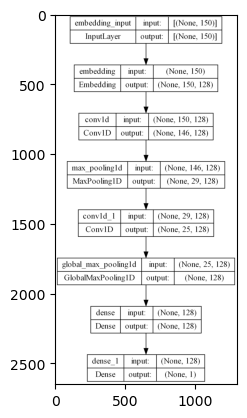

In [20]:
#  Plot Model
print("\nModel Structure:")
plot_model(model, to_file='model_plot.png', dpi=300, show_shapes=True, show_layer_names=True)

plt.imshow(plt.imread('model_plot.png'))
plt.show()

In [21]:
from PIL import Image
im = Image.open('model_plot.png')
im.show()
